In [ ]:
# Cell 1 - runtime check (Colab usually has dependencies preinstalled)
import sys, time, math
print("Python", sys.version.split()[0])
import torch
print("PyTorch", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Python 3.12.11
PyTorch 2.8.0+cu126
Device: cpu


In [ ]:
# Cell 2 - imports & config
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

# reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Cell 3 - model selection & hyperparams
MODEL_TYPE = "mlp"   # "mlp" | "cnn" | "rnn" (used only if RUN_ALL_MODELS=False)
RUN_ALL_MODELS = True  # If True: train MLP, CNN, RNN sequentially and compare accuracies

BATCH_SIZE = 64
LR = 1e-3
N_EPOCHS = 40          # max epochs (early stopping likely to stop earlier)
TEST_SIZE = 0.2
VAL_SIZE = 0.1         # portion of remaining train used as validation
EARLYSTOP_PATIENCE = 6 # epochs to wait for val loss improvement


In [ ]:
# Cell 4 - load digits, normalize, split
digits = datasets.load_digits()
X = digits.images.astype(np.float32)   # (N,8,8), values 0..16
y = digits.target.astype(np.int64)

# Normalize to [0,1]
X = X / 16.0

# Train / val / test splits (stratified)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y)

val_rel = VAL_SIZE / (1 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_rel, random_state=SEED, stratify=y_trainval)

print("Train:", X_train.shape, y_train.shape, "Val:", X_val.shape, y_val.shape, "Test:", X_test.shape, y_test.shape)


Train: (1257, 8, 8) (1257,) Val: (180, 8, 8) (180,) Test: (360, 8, 8) (360,)


In [ ]:
# Cell 5 - helper that returns DataLoaders depending on model_type
def make_dataloaders(model_type, batch_size=BATCH_SIZE):
    if model_type == "mlp":
        Xtr = X_train.reshape(len(X_train), -1)
        Xv  = X_val.reshape(len(X_val), -1)
        Xt  = X_test.reshape(len(X_test), -1)
        to_tensor = lambda x,y: TensorDataset(torch.tensor(x, dtype=torch.float32),
                                              torch.tensor(y, dtype=torch.long))
    elif model_type == "cnn":
        Xtr = X_train[:, None, :, :]   # (N,1,8,8)
        Xv  = X_val[:, None, :, :]
        Xt  = X_test[:, None, :, :]
        to_tensor = lambda x,y: TensorDataset(torch.tensor(x, dtype=torch.float32),
                                              torch.tensor(y, dtype=torch.long))
    elif model_type == "rnn":
        # sequence across rows: (batch, seq_len=8, features=8)
        Xtr = X_train.reshape(len(X_train), 8, 8)
        Xv  = X_val.reshape(len(X_val), 8, 8)
        Xt  = X_test.reshape(len(X_test), 8, 8)
        to_tensor = lambda x,y: TensorDataset(torch.tensor(x, dtype=torch.float32),
                                              torch.tensor(y, dtype=torch.long))
    else:
        raise ValueError("Unknown model_type")

    train_ds = to_tensor(Xtr, y_train)
    val_ds   = to_tensor(Xv, y_val)
    test_ds  = to_tensor(Xt, y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


In [ ]:
# Cell 6 - models
class MLP(nn.Module):
    def __init__(self, input_dim=64, hidden=[128,64], n_classes=10, dropout=0.3):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, n_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class SimpleCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        # (1,8,8) -> conv -> pool -> conv -> pool -> fc
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (32,8,8)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (64,8,8)
        self.bn2 = nn.BatchNorm2d(64)                               # mean of 0 and a standard deviation of 1.
        self.pool = nn.MaxPool2d(2)                              # halves spatial dims
        self.fc1 = nn.Linear(64 * 2 * 2, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, n_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> (32,4,4)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> (64,2,2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

class SimpleRNN(nn.Module):
    def __init__(self, input_size=8, hidden_size=64, n_layers=1, n_classes=10, bidirectional=False, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=n_layers, batch_first=True,
                            bidirectional=bidirectional, dropout=dropout if n_layers>1 else 0.0)
        self.dir_factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * self.dir_factor, n_classes)
    def forward(self, x):
        # x: (batch, seq_len=8, features=8)
        out, (hn, cn) = self.lstm(x)
        # take the last layer's last hidden state
        last_h = hn[-1]
        return self.fc(last_h)


In [ ]:
# Cell 7 - train & evaluate helpers (with early stopping)
def evaluate_model(model, loader, model_type):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            if model_type == "cnn":
                xb = xb.float()
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            probs = F.softmax(out, dim=1)
            preds = probs.argmax(dim=1)
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc, all_labels, all_preds, all_probs

def train_model(model, train_loader, val_loader, model_type, lr=LR, n_epochs=N_EPOCHS, patience=EARLYSTOP_PATIENCE):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    best_state = None
    epochs_no_improve = 0

    for epoch in range(1, n_epochs+1):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        pbar = tqdm(train_loader, desc=f"{model_type} Epoch {epoch}/{n_epochs}", leave=False)
        for xb, yb in pbar:
            xb = xb.to(device)
            yb = yb.to(device)
            if model_type == "cnn":
                xb = xb.float()
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(yb.cpu().numpy())
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(np.concatenate(all_labels), np.concatenate(all_preds))
        val_loss, val_acc, _, _, _ = evaluate_model(model, val_loader, model_type)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Early stopping logic
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f"[{model_type}] Epoch {epoch:02d} — train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")
        if epochs_no_improve >= patience:
            print(f"Early stopping: no improvement in val_loss for {patience} epochs.")
            break

    # load best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history


In [ ]:
# Cell 8 - run training for MODEL_TYPE or for all models
def run_single(model_type):
    print("\n=== Training", model_type.upper(), "===")
    train_loader, val_loader, test_loader = make_dataloaders(model_type)
    if model_type == "mlp":
        model = MLP(input_dim=64, hidden=[128,64], n_classes=10)
    elif model_type == "cnn":
        model = SimpleCNN(n_classes=10)
    elif model_type == "rnn":
        model = SimpleRNN(input_size=8, hidden_size=64, n_layers=1, n_classes=10)
    else:
        raise ValueError("Unknown model type")

    model, history = train_model(model, train_loader, val_loader, model_type)
    test_loss, test_acc, y_true, y_pred, y_probs = evaluate_model(model, test_loader, model_type)
    print(f"Final test acc for {model_type}: {test_acc:.4f}")

    results = {
        "model_type": model_type,
        "model": model,
        "history": history,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_probs": y_probs,
        "test_loader": test_loader
    }
    return results

all_results = []
if RUN_ALL_MODELS:
    for mt in ["mlp", "cnn", "rnn"]:
        res = run_single(mt)
        all_results.append(res)
else:
    all_results.append(run_single(MODEL_TYPE))



=== Training MLP ===


mlp Epoch 1/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 01 — train_loss: 2.2627, train_acc: 0.2220, val_loss: 2.1717, val_acc: 0.5278


mlp Epoch 2/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 02 — train_loss: 2.0685, train_acc: 0.4662, val_loss: 1.8493, val_acc: 0.6944


mlp Epoch 3/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 03 — train_loss: 1.6681, train_acc: 0.6237, val_loss: 1.3298, val_acc: 0.8000


mlp Epoch 4/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 04 — train_loss: 1.2103, train_acc: 0.7009, val_loss: 0.9029, val_acc: 0.8556


mlp Epoch 5/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 05 — train_loss: 0.8860, train_acc: 0.7589, val_loss: 0.6598, val_acc: 0.8778


mlp Epoch 6/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 06 — train_loss: 0.7260, train_acc: 0.7884, val_loss: 0.5247, val_acc: 0.8944


mlp Epoch 7/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 07 — train_loss: 0.5809, train_acc: 0.8313, val_loss: 0.4465, val_acc: 0.9000


mlp Epoch 8/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 08 — train_loss: 0.5122, train_acc: 0.8536, val_loss: 0.3908, val_acc: 0.9167


mlp Epoch 9/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 09 — train_loss: 0.4880, train_acc: 0.8735, val_loss: 0.3388, val_acc: 0.9056


mlp Epoch 10/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 10 — train_loss: 0.3893, train_acc: 0.8839, val_loss: 0.3042, val_acc: 0.9278


mlp Epoch 11/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 11 — train_loss: 0.3709, train_acc: 0.8902, val_loss: 0.2679, val_acc: 0.9389


mlp Epoch 12/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 12 — train_loss: 0.3519, train_acc: 0.8958, val_loss: 0.2534, val_acc: 0.9444


mlp Epoch 13/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 13 — train_loss: 0.3155, train_acc: 0.9085, val_loss: 0.2318, val_acc: 0.9389


mlp Epoch 14/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 14 — train_loss: 0.2935, train_acc: 0.9141, val_loss: 0.2120, val_acc: 0.9500


mlp Epoch 15/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 15 — train_loss: 0.2730, train_acc: 0.9244, val_loss: 0.1961, val_acc: 0.9500


mlp Epoch 16/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 16 — train_loss: 0.2526, train_acc: 0.9276, val_loss: 0.1906, val_acc: 0.9444


mlp Epoch 17/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 17 — train_loss: 0.2347, train_acc: 0.9316, val_loss: 0.1688, val_acc: 0.9556


mlp Epoch 18/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 18 — train_loss: 0.2393, train_acc: 0.9292, val_loss: 0.1626, val_acc: 0.9667


mlp Epoch 19/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 19 — train_loss: 0.2196, train_acc: 0.9364, val_loss: 0.1594, val_acc: 0.9444


mlp Epoch 20/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 20 — train_loss: 0.2039, train_acc: 0.9443, val_loss: 0.1409, val_acc: 0.9611


mlp Epoch 21/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 21 — train_loss: 0.2011, train_acc: 0.9411, val_loss: 0.1362, val_acc: 0.9611


mlp Epoch 22/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 22 — train_loss: 0.1815, train_acc: 0.9459, val_loss: 0.1317, val_acc: 0.9500


mlp Epoch 23/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 23 — train_loss: 0.1737, train_acc: 0.9475, val_loss: 0.1301, val_acc: 0.9500


mlp Epoch 24/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 24 — train_loss: 0.1697, train_acc: 0.9499, val_loss: 0.1180, val_acc: 0.9556


mlp Epoch 25/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 25 — train_loss: 0.1530, train_acc: 0.9523, val_loss: 0.1192, val_acc: 0.9778


mlp Epoch 26/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 26 — train_loss: 0.1654, train_acc: 0.9507, val_loss: 0.1028, val_acc: 0.9667


mlp Epoch 27/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 27 — train_loss: 0.1502, train_acc: 0.9515, val_loss: 0.1146, val_acc: 0.9722


mlp Epoch 28/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 28 — train_loss: 0.1666, train_acc: 0.9467, val_loss: 0.1094, val_acc: 0.9611


mlp Epoch 29/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 29 — train_loss: 0.1343, train_acc: 0.9594, val_loss: 0.0946, val_acc: 0.9667


mlp Epoch 30/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 30 — train_loss: 0.1404, train_acc: 0.9586, val_loss: 0.1047, val_acc: 0.9500


mlp Epoch 31/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 31 — train_loss: 0.1295, train_acc: 0.9666, val_loss: 0.0903, val_acc: 0.9667


mlp Epoch 32/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 32 — train_loss: 0.1174, train_acc: 0.9634, val_loss: 0.1025, val_acc: 0.9556


mlp Epoch 33/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 33 — train_loss: 0.1200, train_acc: 0.9610, val_loss: 0.0809, val_acc: 0.9722


mlp Epoch 34/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 34 — train_loss: 0.1149, train_acc: 0.9666, val_loss: 0.0804, val_acc: 0.9667


mlp Epoch 35/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 35 — train_loss: 0.1085, train_acc: 0.9698, val_loss: 0.0872, val_acc: 0.9667


mlp Epoch 36/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 36 — train_loss: 0.1285, train_acc: 0.9642, val_loss: 0.0826, val_acc: 0.9667


mlp Epoch 37/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 37 — train_loss: 0.1154, train_acc: 0.9690, val_loss: 0.0735, val_acc: 0.9722


mlp Epoch 38/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 38 — train_loss: 0.1009, train_acc: 0.9722, val_loss: 0.0791, val_acc: 0.9722


mlp Epoch 39/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 39 — train_loss: 0.1005, train_acc: 0.9730, val_loss: 0.0810, val_acc: 0.9722


mlp Epoch 40/40:   0%|          | 0/20 [00:00<?, ?it/s]

[mlp] Epoch 40 — train_loss: 0.1053, train_acc: 0.9698, val_loss: 0.0723, val_acc: 0.9778
Final test acc for mlp: 0.9722

=== Training CNN ===


cnn Epoch 1/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 01 — train_loss: 1.6841, train_acc: 0.5290, val_loss: 1.7064, val_acc: 0.8000


cnn Epoch 2/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 02 — train_loss: 0.7042, train_acc: 0.8496, val_loss: 0.5067, val_acc: 0.9167


cnn Epoch 3/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 03 — train_loss: 0.3145, train_acc: 0.9316, val_loss: 0.1876, val_acc: 0.9778


cnn Epoch 4/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 04 — train_loss: 0.1847, train_acc: 0.9602, val_loss: 0.1077, val_acc: 0.9833


cnn Epoch 5/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 05 — train_loss: 0.1238, train_acc: 0.9737, val_loss: 0.0745, val_acc: 0.9833


cnn Epoch 6/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 06 — train_loss: 0.0809, train_acc: 0.9873, val_loss: 0.0622, val_acc: 0.9889


cnn Epoch 7/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 07 — train_loss: 0.0704, train_acc: 0.9873, val_loss: 0.0495, val_acc: 0.9944


cnn Epoch 8/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 08 — train_loss: 0.0608, train_acc: 0.9897, val_loss: 0.0437, val_acc: 0.9944


cnn Epoch 9/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 09 — train_loss: 0.0441, train_acc: 0.9944, val_loss: 0.0459, val_acc: 0.9889


cnn Epoch 10/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 10 — train_loss: 0.0391, train_acc: 0.9936, val_loss: 0.0386, val_acc: 0.9889


cnn Epoch 11/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 11 — train_loss: 0.0303, train_acc: 0.9960, val_loss: 0.0423, val_acc: 0.9833


cnn Epoch 12/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 12 — train_loss: 0.0232, train_acc: 0.9960, val_loss: 0.0255, val_acc: 0.9944


cnn Epoch 13/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 13 — train_loss: 0.0201, train_acc: 0.9976, val_loss: 0.0294, val_acc: 0.9944


cnn Epoch 14/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 14 — train_loss: 0.0174, train_acc: 1.0000, val_loss: 0.0215, val_acc: 0.9889


cnn Epoch 15/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 15 — train_loss: 0.0130, train_acc: 1.0000, val_loss: 0.0290, val_acc: 0.9944


cnn Epoch 16/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 16 — train_loss: 0.0137, train_acc: 0.9976, val_loss: 0.0161, val_acc: 0.9944


cnn Epoch 17/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 17 — train_loss: 0.0117, train_acc: 0.9984, val_loss: 0.0321, val_acc: 0.9944


cnn Epoch 18/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 18 — train_loss: 0.0121, train_acc: 0.9992, val_loss: 0.0244, val_acc: 0.9889


cnn Epoch 19/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 19 — train_loss: 0.0104, train_acc: 0.9992, val_loss: 0.0298, val_acc: 0.9944


cnn Epoch 20/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 20 — train_loss: 0.0067, train_acc: 0.9992, val_loss: 0.0186, val_acc: 0.9944


cnn Epoch 21/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 21 — train_loss: 0.0077, train_acc: 0.9992, val_loss: 0.0219, val_acc: 0.9944


cnn Epoch 22/40:   0%|          | 0/20 [00:00<?, ?it/s]

[cnn] Epoch 22 — train_loss: 0.0063, train_acc: 0.9992, val_loss: 0.0220, val_acc: 0.9944
Early stopping: no improvement in val_loss for 6 epochs.
Final test acc for cnn: 0.9917

=== Training RNN ===


rnn Epoch 1/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 01 — train_loss: 2.2983, train_acc: 0.0971, val_loss: 2.2849, val_acc: 0.1000


rnn Epoch 2/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 02 — train_loss: 2.2697, train_acc: 0.1416, val_loss: 2.2424, val_acc: 0.2278


rnn Epoch 3/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 03 — train_loss: 2.1767, train_acc: 0.2474, val_loss: 2.0314, val_acc: 0.3778


rnn Epoch 4/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 04 — train_loss: 1.8279, train_acc: 0.4288, val_loss: 1.5524, val_acc: 0.6167


rnn Epoch 5/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 05 — train_loss: 1.3768, train_acc: 0.6245, val_loss: 1.1616, val_acc: 0.7000


rnn Epoch 6/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 06 — train_loss: 1.0790, train_acc: 0.6977, val_loss: 0.9493, val_acc: 0.7722


rnn Epoch 7/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 07 — train_loss: 0.8813, train_acc: 0.7661, val_loss: 0.8130, val_acc: 0.7833


rnn Epoch 8/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 08 — train_loss: 0.7560, train_acc: 0.7892, val_loss: 0.7467, val_acc: 0.7889


rnn Epoch 9/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 09 — train_loss: 0.7076, train_acc: 0.7812, val_loss: 0.6672, val_acc: 0.8056


rnn Epoch 10/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 10 — train_loss: 0.6293, train_acc: 0.8075, val_loss: 0.6287, val_acc: 0.8444


rnn Epoch 11/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 11 — train_loss: 0.5984, train_acc: 0.8035, val_loss: 0.6108, val_acc: 0.8333


rnn Epoch 12/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 12 — train_loss: 0.5438, train_acc: 0.8361, val_loss: 0.5622, val_acc: 0.8611


rnn Epoch 13/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 13 — train_loss: 0.4921, train_acc: 0.8536, val_loss: 0.5556, val_acc: 0.8222


rnn Epoch 14/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 14 — train_loss: 0.4632, train_acc: 0.8695, val_loss: 0.5291, val_acc: 0.8611


rnn Epoch 15/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 15 — train_loss: 0.4372, train_acc: 0.8751, val_loss: 0.5031, val_acc: 0.8667


rnn Epoch 16/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 16 — train_loss: 0.4137, train_acc: 0.8775, val_loss: 0.4820, val_acc: 0.8556


rnn Epoch 17/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 17 — train_loss: 0.3942, train_acc: 0.8839, val_loss: 0.4714, val_acc: 0.8944


rnn Epoch 18/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 18 — train_loss: 0.3821, train_acc: 0.8870, val_loss: 0.4638, val_acc: 0.8556


rnn Epoch 19/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 19 — train_loss: 0.3626, train_acc: 0.8894, val_loss: 0.4308, val_acc: 0.9056


rnn Epoch 20/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 20 — train_loss: 0.3381, train_acc: 0.8950, val_loss: 0.4228, val_acc: 0.8944


rnn Epoch 21/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 21 — train_loss: 0.3251, train_acc: 0.9101, val_loss: 0.4069, val_acc: 0.9111


rnn Epoch 22/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 22 — train_loss: 0.3044, train_acc: 0.9157, val_loss: 0.4243, val_acc: 0.9000


rnn Epoch 23/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 23 — train_loss: 0.2909, train_acc: 0.9125, val_loss: 0.3988, val_acc: 0.8944


rnn Epoch 24/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 24 — train_loss: 0.2694, train_acc: 0.9236, val_loss: 0.3881, val_acc: 0.9111


rnn Epoch 25/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 25 — train_loss: 0.2566, train_acc: 0.9260, val_loss: 0.3790, val_acc: 0.9056


rnn Epoch 26/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 26 — train_loss: 0.2557, train_acc: 0.9284, val_loss: 0.3645, val_acc: 0.9000


rnn Epoch 27/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 27 — train_loss: 0.2475, train_acc: 0.9308, val_loss: 0.3580, val_acc: 0.9056


rnn Epoch 28/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 28 — train_loss: 0.2286, train_acc: 0.9348, val_loss: 0.3417, val_acc: 0.9389


rnn Epoch 29/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 29 — train_loss: 0.2166, train_acc: 0.9419, val_loss: 0.3556, val_acc: 0.9056


rnn Epoch 30/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 30 — train_loss: 0.2085, train_acc: 0.9459, val_loss: 0.3554, val_acc: 0.9111


rnn Epoch 31/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 31 — train_loss: 0.2010, train_acc: 0.9475, val_loss: 0.3505, val_acc: 0.9167


rnn Epoch 32/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 32 — train_loss: 0.1989, train_acc: 0.9491, val_loss: 0.3423, val_acc: 0.9167


rnn Epoch 33/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 33 — train_loss: 0.1853, train_acc: 0.9554, val_loss: 0.3286, val_acc: 0.9111


rnn Epoch 34/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 34 — train_loss: 0.1839, train_acc: 0.9483, val_loss: 0.3200, val_acc: 0.9222


rnn Epoch 35/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 35 — train_loss: 0.1727, train_acc: 0.9594, val_loss: 0.3083, val_acc: 0.9222


rnn Epoch 36/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 36 — train_loss: 0.1642, train_acc: 0.9531, val_loss: 0.3014, val_acc: 0.9222


rnn Epoch 37/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 37 — train_loss: 0.1580, train_acc: 0.9547, val_loss: 0.3009, val_acc: 0.9222


rnn Epoch 38/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 38 — train_loss: 0.1494, train_acc: 0.9594, val_loss: 0.3205, val_acc: 0.9222


rnn Epoch 39/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 39 — train_loss: 0.1503, train_acc: 0.9586, val_loss: 0.2984, val_acc: 0.9444


rnn Epoch 40/40:   0%|          | 0/20 [00:00<?, ?it/s]

[rnn] Epoch 40 — train_loss: 0.1408, train_acc: 0.9650, val_loss: 0.3070, val_acc: 0.9222
Final test acc for rnn: 0.9278


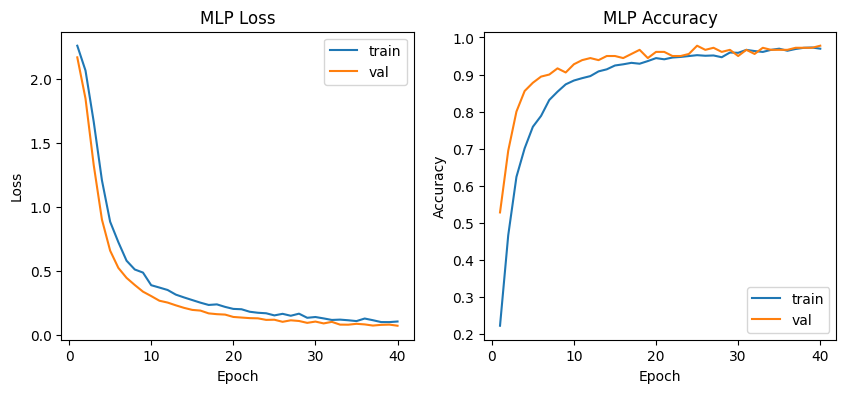

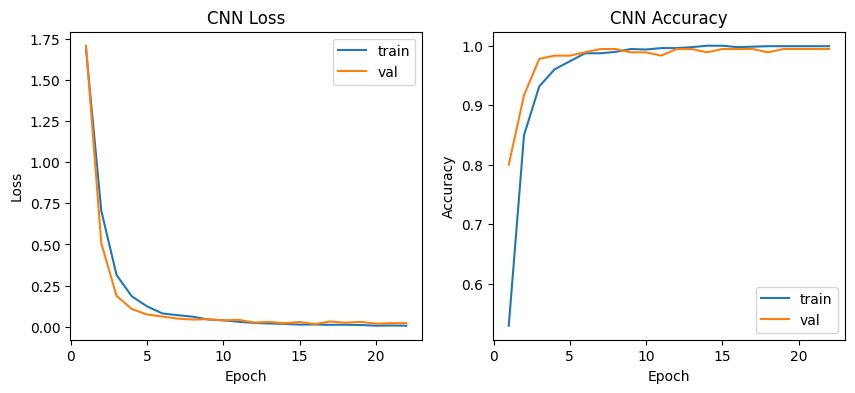

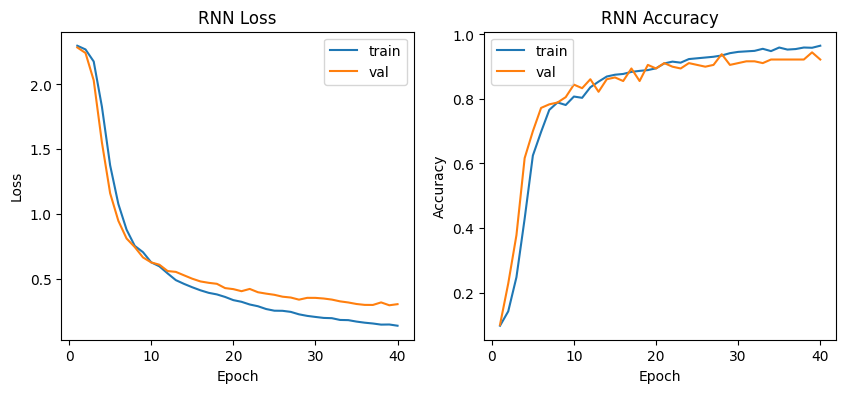

In [ ]:
# Cell 9 - plot loss & accuracy curves for each model
for res in all_results:
    hist = res["history"]
    epochs = np.arange(1, len(hist["train_loss"]) + 1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist["train_loss"], label="train")
    plt.plot(epochs, hist["val_loss"], label="val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{res['model_type'].upper()} Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist["train_acc"], label="train")
    plt.plot(epochs, hist["val_acc"], label="val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{res['model_type'].upper()} Accuracy"); plt.legend()
    plt.show()



=== Results for MLP ===
Test accuracy: 0.9722  Test loss: 0.0845

Classification report:

              precision    recall  f1-score   support

           0     1.0000    0.9722    0.9859        36
           1     0.8919    0.9167    0.9041        36
           2     1.0000    1.0000    1.0000        35
           3     1.0000    0.9730    0.9863        37
           4     0.9474    1.0000    0.9730        36
           5     0.9737    1.0000    0.9867        37
           6     1.0000    1.0000    1.0000        36
           7     0.9730    1.0000    0.9863        36
           8     0.9688    0.8857    0.9254        35
           9     0.9722    0.9722    0.9722        36

    accuracy                         0.9722       360
   macro avg     0.9727    0.9720    0.9720       360
weighted avg     0.9727    0.9722    0.9721       360



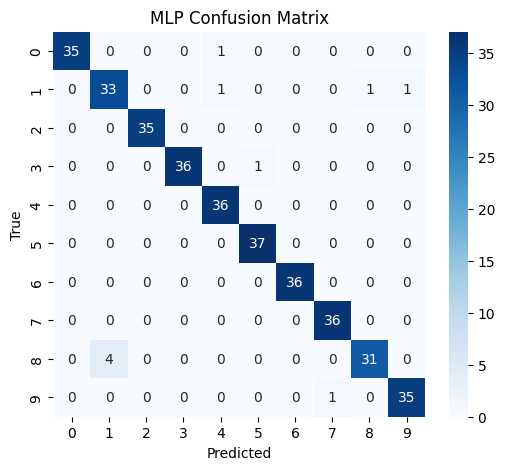


=== Results for CNN ===
Test accuracy: 0.9917  Test loss: 0.0404

Classification report:

              precision    recall  f1-score   support

           0     1.0000    0.9722    0.9859        36
           1     0.9474    1.0000    0.9730        36
           2     1.0000    1.0000    1.0000        35
           3     1.0000    1.0000    1.0000        37
           4     0.9730    1.0000    0.9863        36
           5     1.0000    1.0000    1.0000        37
           6     1.0000    1.0000    1.0000        36
           7     1.0000    1.0000    1.0000        36
           8     1.0000    0.9429    0.9706        35
           9     1.0000    1.0000    1.0000        36

    accuracy                         0.9917       360
   macro avg     0.9920    0.9915    0.9916       360
weighted avg     0.9920    0.9917    0.9917       360



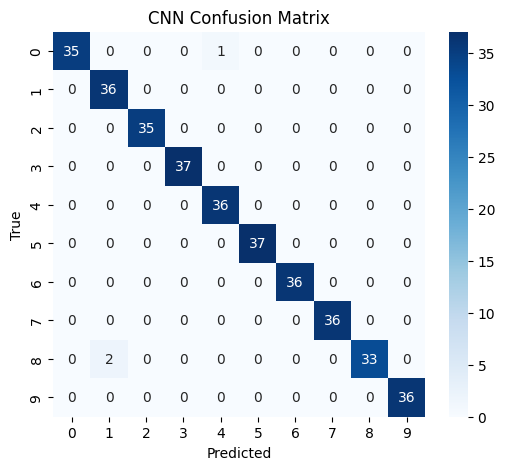


=== Results for RNN ===
Test accuracy: 0.9278  Test loss: 0.2261

Classification report:

              precision    recall  f1-score   support

           0     0.9730    1.0000    0.9863        36
           1     1.0000    0.8056    0.8923        36
           2     0.8333    1.0000    0.9091        35
           3     0.9231    0.9730    0.9474        37
           4     0.9722    0.9722    0.9722        36
           5     0.9231    0.9730    0.9474        37
           6     0.8718    0.9444    0.9067        36
           7     0.8919    0.9167    0.9041        36
           8     1.0000    0.8000    0.8889        35
           9     0.9412    0.8889    0.9143        36

    accuracy                         0.9278       360
   macro avg     0.9330    0.9274    0.9269       360
weighted avg     0.9330    0.9278    0.9271       360



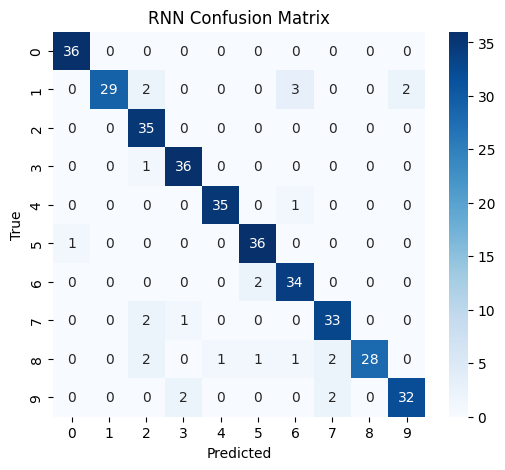

In [ ]:
# Cell 10 - confusion matrix and classification report
for res in all_results:
    print("\n=== Results for", res["model_type"].upper(), "===")
    print(f"Test accuracy: {res['test_acc']:.4f}  Test loss: {res['test_loss']:.4f}\n")
    print("Classification report:\n")
    print(classification_report(res["y_true"], res["y_pred"], digits=4))
    cm = confusion_matrix(res["y_true"], res["y_pred"])
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"{res['model_type'].upper()} Confusion Matrix")
    plt.show()


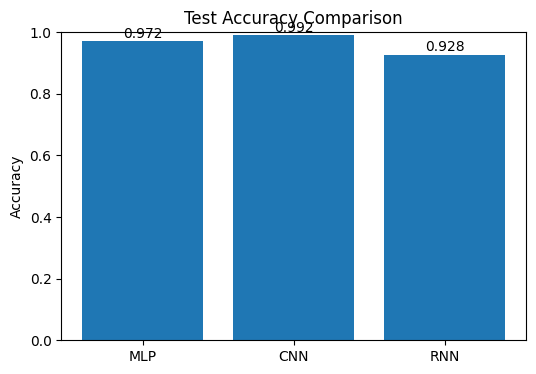

In [ ]:
# Cell 12 - accuracy comparison
names = [r["model_type"].upper() for r in all_results]
accs  = [r["test_acc"] for r in all_results]

plt.figure(figsize=(6,4))
bars = plt.bar(names, accs)
plt.ylim(0,1)
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
for bar, acc in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.01, f"{acc:.3f}", ha='center')
plt.show()



MLP - Misclassified: 10


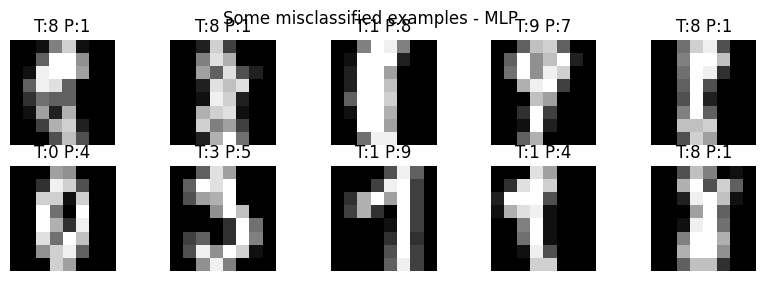


CNN - Misclassified: 3


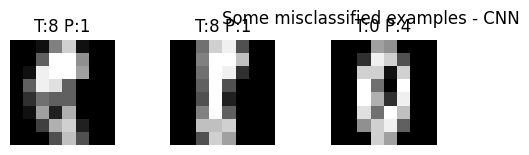


RNN - Misclassified: 26


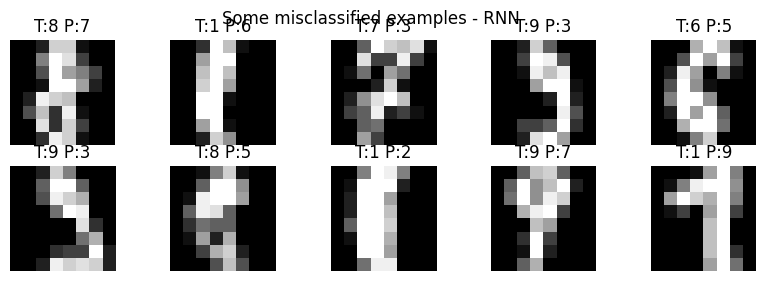

In [ ]:
# Cell 13 - show misclassified examples (uses X_test)
for res in all_results:
    idxs = np.where(res["y_true"] != res["y_pred"])[0]
    print(f"\n{res['model_type'].upper()} - Misclassified: {len(idxs)}")
    if len(idxs) == 0:
        continue
    plt.figure(figsize=(10,3))
    for i, idx in enumerate(idxs[:10]):
        plt.subplot(2,5,i+1)
        img = X_test[idx]  # normalized to [0,1]
        plt.imshow(img, cmap="gray")
        plt.title(f"T:{res['y_true'][idx]} P:{res['y_pred'][idx]}")
        plt.axis("off")
    plt.suptitle(f"Some misclassified examples - {res['model_type'].upper()}")
    plt.show()


Q1. CA: Updated weights after 1 epoch:

w1​≈0.1516
w2​≈0.07046​


Q2. Calculation is wrong.
CA: MSE=0.5*(0.03016+0.02479)​= 0.0275   #martin_galvan, justin, rohan, trevor